## Load Dependencies

In [1]:
%matplotlib inline
%load_ext Cython

In [98]:
import numpy as np
import timeit
import copy
import pandas as pd
import glob
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import cv2
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns
import pickle
import librosa as lb
import time
import cProfile
import os
import os.path
import pyximport; pyximport.install()
import multiprocessing
from ExtractBootlegFeatures import *

## Get bootleg score of query image

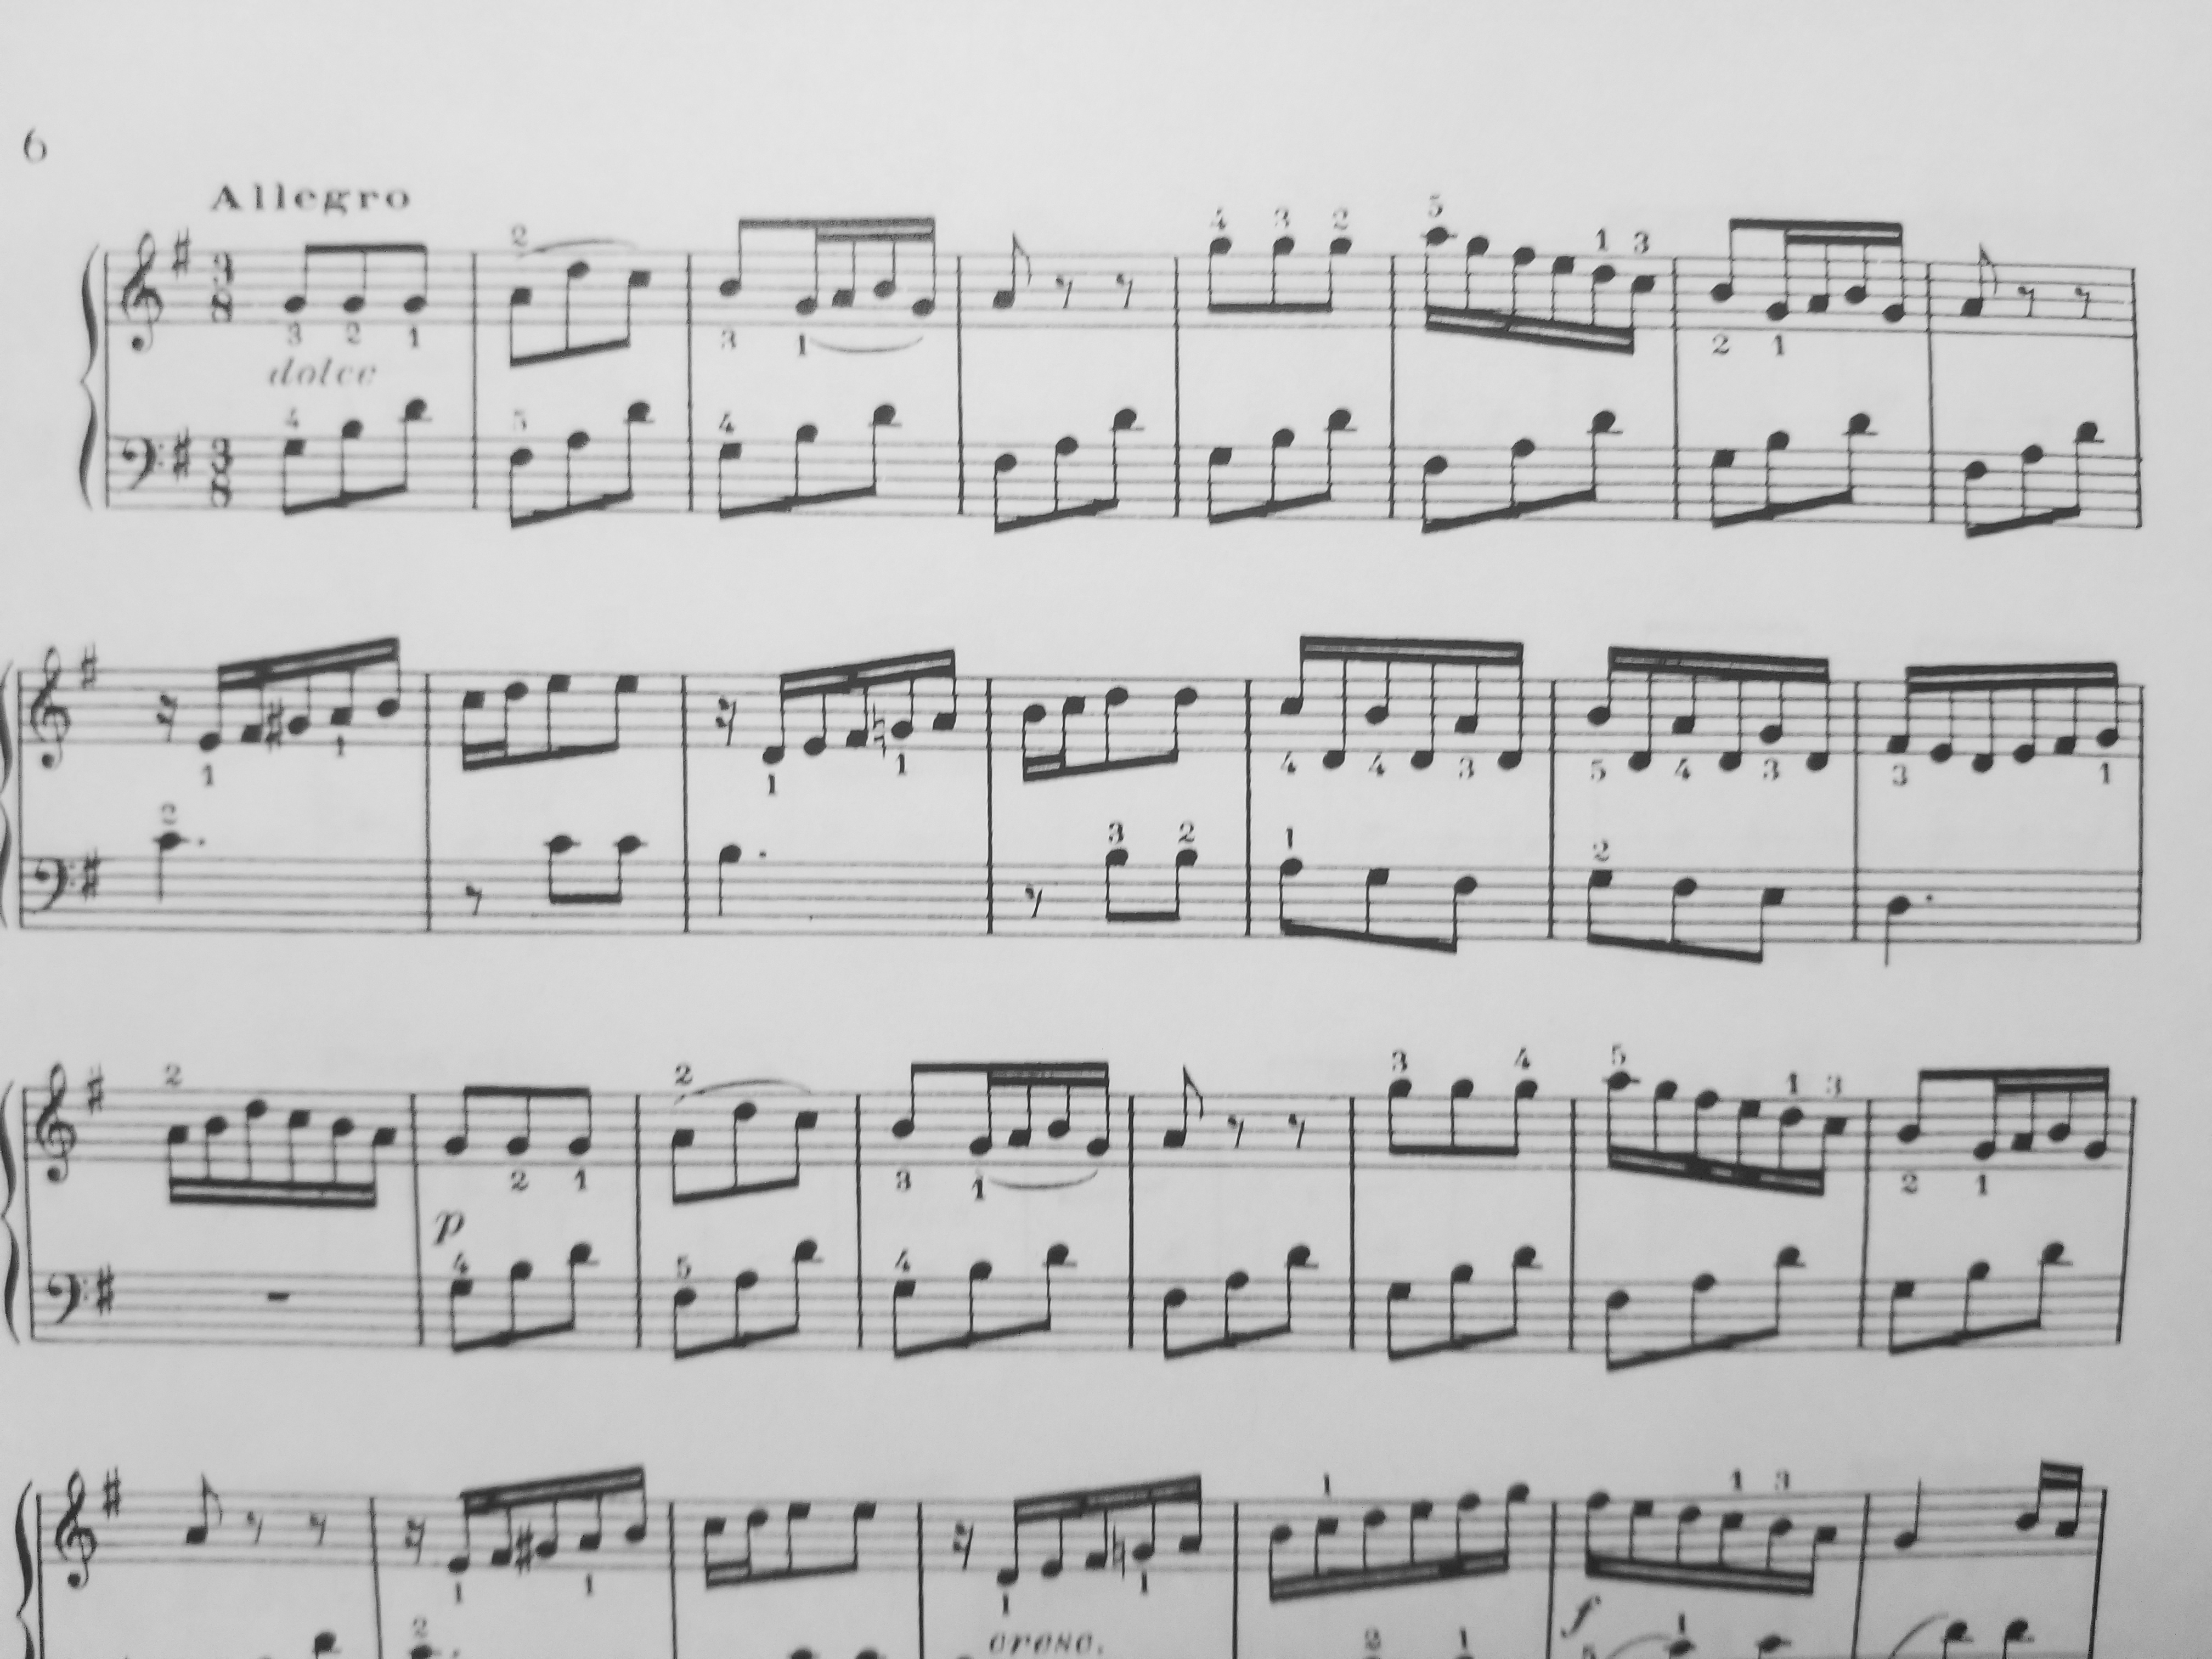

In [178]:
imagefile = 'data/queries/p41_q2.jpg'
pim1 = Image.open(imagefile).convert('L')
pim1

Processing data/queries/p41_q2.jpg


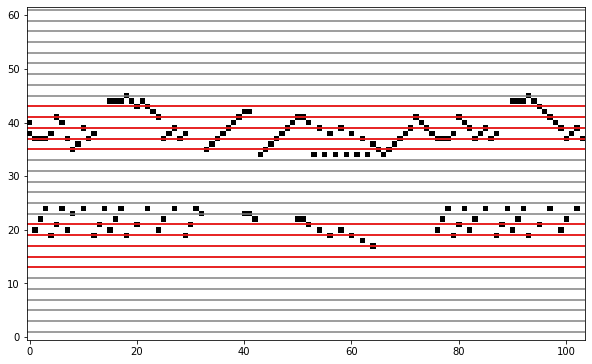

In [179]:
bscore_query=processQuery(imagefile)
visualizeLongBootlegScore(bscore_query, [13,15,17,19,21,35,37,39,41,43])

In [180]:
bscore_query.shape

(62, 104)

In [281]:
transposed = bscore_query.T
ints = transposed.dot(1 << np.arange(transposed.shape[-1] - 1, -1, -1))
ints = np.array([int(l) for l in ints])

In [282]:
def unpackbits(x, num_bits):
    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])
    return np.flip((x & mask).astype(bool).astype(float), 1).T

In [283]:
unpacked = unpackbits(ints, 62)

In [294]:
%timeit unpackbits(ints, 62)

37.9 µs ± 696 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Linear mapping

In [303]:
def premultiply(h, w, m):
    return np.random.uniform(-1., 1., (h,w)) @ m

In [295]:
%timeit premultiply(32, 62, bscore_query)

UsageError: Line magic function `%timeitpremultiply(bscore_query)` not found.


In [241]:
b = premultiply(32, 62, bscore_query)

In [251]:
def threshold(m):
    return (m > 0).astype(int)

In [252]:
%timeit threshold(b)

6.26 µs ± 153 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [253]:
thresholded = threshold(b)

In [322]:
def bits_to_int(bits):
    m,n = bits.shape # number of columns is needed, not bits.size
    a = 2**np.arange(m)[::-1]  # -1 reverses array of powers of 2 of same length as bits
    return a @ bits  # this matmult is the key line of code

In [280]:
%timeit bits_to_int(thresholded)

8.89 µs ± 158 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [334]:
def linear_mapping_convert(ints):
    bscore = unpackbits(ints, 62)
    b = premultiply(32, 62, bscore)
    m = threshold(b)
    return bits_to_int(m)

In [333]:
def linear_mapping(bscore):
    b = premultiply(32, 62, bscore)
    m = threshold(b)
    return bits_to_int(m)

In [326]:
%timeit linear_mapping(bscore_query)

77.9 µs ± 95 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [335]:
%timeit linear_mapping_convert(ints)

301 µs ± 19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 2-layer NN

In [300]:
%timeit premultiply(48, 62, bscore_query)

67.3 µs ± 51.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [304]:
m = premultiply(48, 62, bscore_query)

In [318]:
def relu(x):
    return np.maximum(x, 0)

In [319]:
%timeit relu(m)

6.71 µs ± 40.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [320]:
b = relu(m)

In [321]:
%timeit premultiply(32, 48, b)

42.4 µs ± 650 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [336]:
def two_layer(bscore):
    b = relu(premultiply(48, 62, bscore))
    m = threshold(premultiply(32, 48, b))
    return bits_to_int(m)

In [338]:
def two_layer_convert(ints):
    bscore = unpackbits(ints, 62)
    b = relu(premultiply(48, 62, bscore))
    m = threshold(premultiply(32, 48, b))
    return bits_to_int(m)

In [337]:
%timeit two_layer(bscore_query)

237 µs ± 6.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [339]:
%timeit two_layer_convert(ints)

628 µs ± 340 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Three-layer NN

In [340]:
%timeit premultiply(52, 62, bscore_query)

67.4 µs ± 65.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [341]:
m = premultiply(52, 62, bscore_query)

In [342]:
%timeit relu(m)

22.1 µs ± 3.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [343]:
b = relu(m)

In [344]:
%timeit premultiply(40, 52, b)

59.3 µs ± 706 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [345]:
m2 = premultiply(40, 52, b)

In [346]:
%timeit relu(m2)

10.8 µs ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [347]:
b2 = relu(m2)

In [348]:
%timeit premultiply(32, 40, b2)

37.7 µs ± 835 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [353]:
def three_layer(bscore):
    b = relu(premultiply(52, 62, bscore))
    m = relu(premultiply(40, 52, b))
    l = threshold(premultiply(32, 40, m))
    return bits_to_int(m)

In [354]:
%timeit three_layer(bscore_query)

308 µs ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [355]:
def three_layer_convert(ints):
    bscore = unpackbits(ints, 62)
    bb = relu(premultiply(52, 62, bscore))
    m = relu(premultiply(40, 52, b))
    l = threshold(premultiply(32, 40, m))
    return bits_to_int(m)

In [356]:
%timeit three_layer_convert(ints)

740 µs ± 8.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
